### What I need:


* A function to load the data
* A function to compute PWM
* A function to compute PSSM
* A function to search for a given PSSM in a sequence and store the probabilities of each kmer 
* Replace the kmer by randomly choosing a kmer based on its probability 
* Update the PSSM
* Iterate through all the sequences until no additional changes are observed
* A function to calculate 
* A function to compute the information content


# Main idea

* Randomly select a kmer from each of the n sequences
* Choose a sequence, throw it away and compute the PSSM of the remaining sequences
* Stochastic PSSM update -> Replace the kmer by randomly choosing a kmer based on its probability 
* Update the PSSM
* Iterate through all the sequences until no additional changes are observed or until a desired number of iterations are completed

In [11]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

Build a function to load the sequences

In [12]:
def load_sequences(path_to_sequences):
    seq_dic ={}
    seq = open(path_to_sequences, 'r')
    for i ,line in enumerate(seq):
        seq_dic['seq' + str(i)] = line.strip()
    return seq_dic

Build a function that takes as input a sequence string and returns the frequency of the nucleotides

In [13]:
#Write a function that calculates nucleotiude frequences
def nuccomp(sequence):
    #This function takes as input a sequence and outouts  numpy array of the frequence of each nucleaotide
    #The order of the output is A, T, G, C
    import numpy as np
    nucfreq = [0,0,0,0]
    nuc = ['A', 'T', 'G', 'C']
    for i in range(len(nuc)):
        nucfreq[i] = sequence.count(nuc[i])
    nucfreq = np.array(nucfreq)/len(sequence)
    return nucfreq

Build a function that takes as input a list sequence strings and returns the corresponding PWM.

In [14]:
def pwm(sequences):
    # This function takes as input a list of equal length sequences and produces a pwm of size (4, 100)
    nuc = ['A', 'C', 'G', 'T']
    profile=[[0 for i in range(len(sequences[0]))] for j in range(len(nuc))]
    
    for instance in sequences:
        for j in range(len(instance)):
            residue=instance[j]
            profile[nuc.index(residue)][j]+=1
            profile[nuc.index(residue)][j]=float(profile[nuc.index(residue)][j])
    import numpy as np
    pwm = np.array(profile)
    pwm = pwm/len(sequences)
    return(pwm)

Build a function that takes as input a PWM as a numpy array and the background frequences of the nucleotides and returns the corresponding PSSM.

In [15]:
def pssm(pwm, nucfreqs):
    #This function takes as input a PWM as a numpy array of shape (4, 100) and a background nucleotide frequency array of shape (1, 4) and computres and returns a PSSM
    import numpy as np
    import math
    pseudocount=0.01
    pssm=[[0 for i in range(len(pwm[0]))] for j in range(len(nucfreqs))]
    for i in range(len(nucfreqs)):
        pssm[i]=(np.array(pwm[i])+pseudocount)/nucfreqs[i]
    for i in range(len(pssm)):
        for k in range(len(pssm[0])):
            pssm[i][k]=math.log(pssm[i][k])/math.log(2)
    return(np.array(pssm))

Build a function that takes as inputs a PSSM and a sequence and scans the sequence with the PSSM. The function returns a dictionary with keys the kmers and as values a tuple of the index of the kmer in the sequence and the corresonding score based on the PSSM

In [16]:
def pssmSearch(pssm, sequence, threshold):
    #This function takes as input a pssm computed form a set of small sequences
    # A longer target sequence i want to scan 
    # A matching threshold
    
	#The function returns a dictionary where keys are kmers and values the index of the kmer in the target sequence and the matching score
    nuc = ['A', 'T', 'G', 'C']
    hits = []
    instances = []
    x = [] #A list that holds indexes for the second step
    allscores = [] #for plotting reasons

    # Step 1: Calculation of the maximum possible pssm score
    maxPssm = 0
    #Compute the maximum PSSM value. This is the sum of the max of each column in the PSSM matrix
    for j in range(len(pssm[0])): #This essentially gives me the lenth of each sequence.
        maxPssm = maxPssm + max(pssm[:,j]) 
        #This means add to max the maximum value of the jth column pssm[:,j] is the jth column of the pssm array
        #Note that although I am computing probability I am using the sum of the pssm values and not their product.
        #This is because at the last step of the pssm function I log transformed the frequences


    # Step 2: Search 
    kmer_dictionary = {}
    for i in range(len(sequence) - len(pssm[0])):
        x.append(i)
        instance = sequence[i:i+len(pssm[0])] #This is a kmer
        # print(instance)
        score = 0
        for l in range(len(instance)):
            score = score + pssm[nuc.index(instance[l])][l]
        kmer_dictionary[instance] = (i,score.item())
    return kmer_dictionary

Build a function that computes the information content of a PWM matrix

In [17]:
def information_content(pwm):
    import math
    I_list = []
    for pos in pwm.T.tolist():
        I = 0
        for nuc in pos:
        #If statement is used because log(0) returns error
            if nuc != 0:
                #print(nuc)
                info = nuc*math.log2(nuc)
                I = I + info
                    #print(info)
        I_list.append(2+I)

    return sum(I_list)

### Define the parameters

In [18]:
path_to_sequnces = f'{os.getcwd()}/data_for_assignments/motifs_in_sequence.fa'
seq_dic = load_sequences(path_to_sequnces)

k = 4
number_of_iterations =20
num_of_seq = len(seq_dic)
length_of_seq = len(seq_dic['seq0'])



Run a Gibbs Sample where a PSSM is initialized by randomly selecting a kmer from each sequence. The update is done by replacing the kmer that corresponds to each sequence with the best matching one after scanning the sequence with the PSSM. Finally update the PSSM

{'seq0': 3, 'seq1': 8, 'seq2': 70, 'seq3': 67, 'seq4': 2, 'seq5': 23, 'seq6': 97, 'seq7': 53, 'seq8': 23, 'seq9': 73, 'seq10': 27, 'seq11': 87, 'seq12': 30, 'seq13': 17, 'seq14': 80, 'seq15': 51, 'seq16': 42, 'seq17': 28, 'seq18': 6, 'seq19': 46, 'seq20': 33, 'seq21': 70, 'seq22': 34, 'seq23': 52, 'seq24': 53, 'seq25': 70, 'seq26': 23, 'seq27': 52, 'seq28': 81, 'seq29': 26, 'seq30': 87, 'seq31': 16, 'seq32': 35, 'seq33': 74, 'seq34': 66, 'seq35': 93, 'seq36': 35, 'seq37': 50, 'seq38': 53, 'seq39': 86, 'seq40': 13, 'seq41': 68, 'seq42': 32, 'seq43': 32, 'seq44': 15, 'seq45': 72, 'seq46': 16, 'seq47': 7, 'seq48': 90, 'seq49': 33}


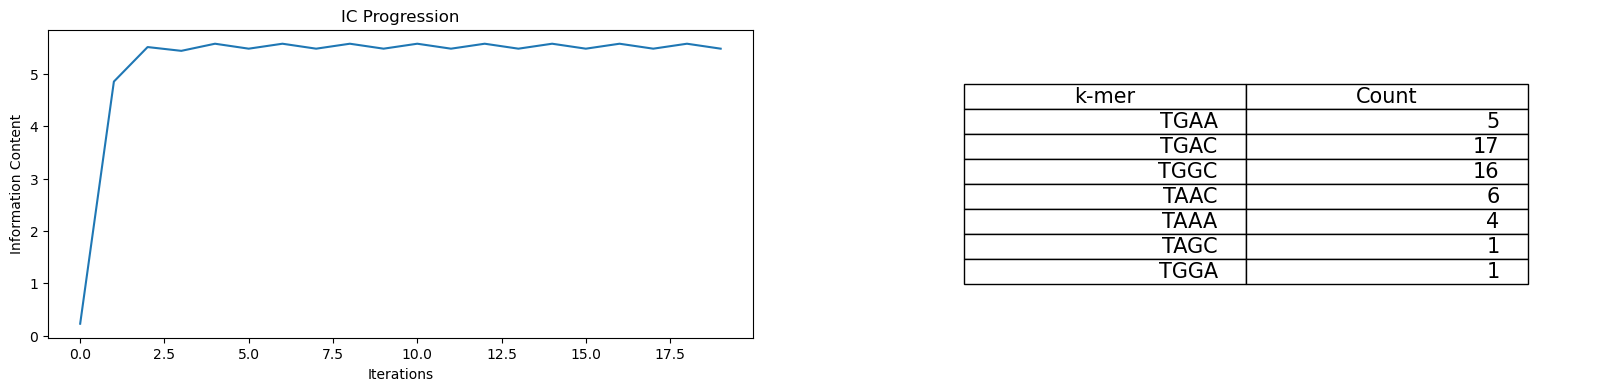

In [48]:
working_dir = os.getcwd()
ic = []

# Step 1: Initialization
# ##Create a dictionary that randomly chooses indexes for kmers in each sequene
import random
random_indeces_dix = {key : random.randint(0, (length_of_seq - k) + 1) for key in seq_dic.keys()}
print(random_indeces_dix)
#random_indexes_dix

#Crate a list of random kmers
initial_kmers_dic = {}
initial_kmers_dic = {key: seq[random_indeces_dix[key]:random_indeces_dix[key] + k] for key,seq in seq_dic.items()}
list_for_update = [initial_kmers_dic[key] for key in seq_dic.keys()]


for _ in range(number_of_iterations):
    current_pwm = pwm(list_for_update)
    current_pssm = pssm(nucfreqs=nuccomp(''.join(list_for_update)), pwm = current_pwm)
    ic.append(information_content(current_pwm))
    for y, seq in enumerate(seq_dic.values()):

        scan = pssmSearch(pssm=current_pssm, sequence=seq, threshold=0)
        best_kmer = max(scan, key=lambda k: scan[k][1])
        list_for_update[y] = best_kmer
        
        
                
kmer_dictionary = dict(zip(list_for_update, len(list_for_update) * [0]))
for kmer in list_for_update:
    kmer_dictionary[kmer] +=1

# Plot the IC
fig, (ax1, ax2) = plt.subplots(figsize = (20,4), ncols = 2)  
ax1.plot(ic)
ax1.set_ylabel('Information Content')
ax1.set_xlabel('Iterations')        
ax1.set_title('IC Progression')


cell_text = [[k, v] for k, v in kmer_dictionary.items()]
col_labels = ['k-mer', 'Count']
ax2.axis('off')
ax2.axis('tight')
table = ax2.table(cellText=cell_text, colLabels=col_labels, loc='center')
table.scale(0.8, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(15)
plt.savefig(f'{working_dir}/figures/ic_over_iterations', dpi=300, bbox_inches='tight')

Run a Gibbs Sampler where a PSSM is initialized by randomly selecting a kmer from each sequence. The update is done by replacing the kmer that corresponds to each sequence with an other kmer based on score to probability mappings after scanning the sequence with the PSSM. Finally update the PSSM

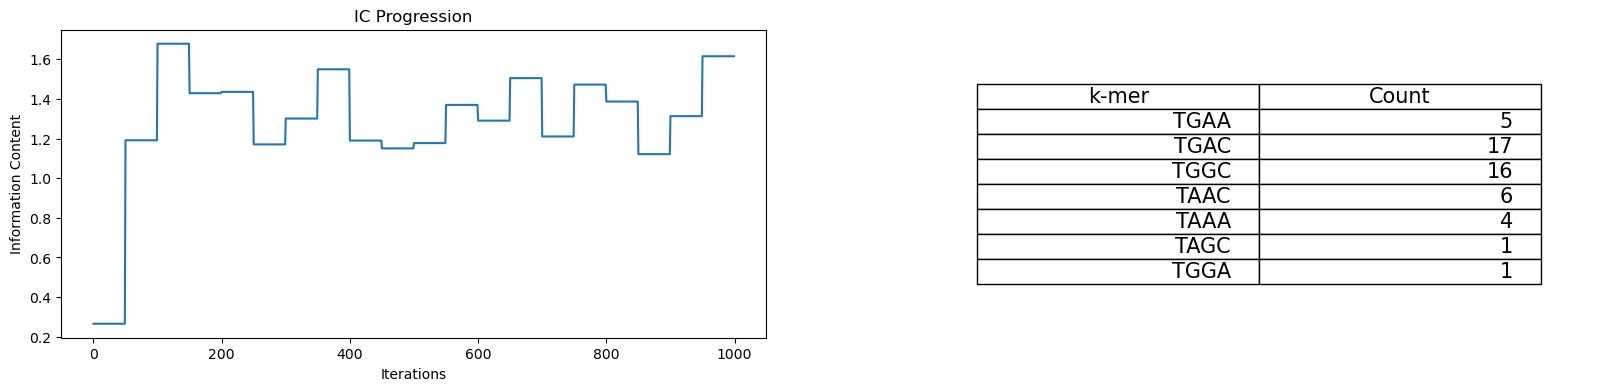

In [51]:
ic = []

# Step 1: Initialization
# ##Create a dictionary that randomly chooses indexes for kmers in each sequene
import random
import math
random_indeces_dix = {key : random.randint(0, (length_of_seq - k) + 1) for key in seq_dic.keys()}
#random_indexes_dix

#Crate a list of random kmers
initial_kmers_dic = {}
initial_kmers_dic = {key: seq[random_indeces_dix[key]:random_indeces_dix[key] + k] for key,seq in seq_dic.items()}
list_for_update = list(initial_kmers_dic.values()) #Here is the mistake because I have already set the initial_kmers


for _ in range(number_of_iterations):
    current_pwm = pwm(list_for_update)
    current_pssm = pssm(nucfreqs=nuccomp(''.join(list_for_update)), pwm = current_pwm)
    for j, seq in enumerate(seq_dic.values()):
        
        scan = pssmSearch(pssm=current_pssm, sequence=seq, threshold=0)
        number_of_kmers = len(scan)
        probs = [value[1] for value in scan.values()]
        weights = [v if (v > 0 and math.isfinite(v)) else 0.01 for v in probs]
        
        kmers = list(scan.keys())
        weighted_choice = random.choices(kmers, weights=weights, k=1)[0]
        list_for_update[j] = weighted_choice
        
        
        ic.append(information_content(current_pwm))


kmer_dictionary = dict(zip(list_for_update, len(list_for_update) * [0]))
for kmer in list_for_update:
    kmer_dictionary[kmer] +=1

# Plot the IC
fig, (ax1, ax2) = plt.subplots(figsize = (20,4), ncols = 2)  
ax1.plot(ic)
ax1.set_ylabel('Information Content')
ax1.set_xlabel('Iterations')        
ax1.set_title('IC Progression')


cellText = [[k, v] for k, v in kmer_dictionary.items()]
colLabels = ['k-mer', 'Count']
ax2.axis('off')
ax2.axis('tight')
table = ax2.table(cellText=cell_text, colLabels=col_labels, loc='center')
table.scale(0.8, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(15)
plt.savefig(f'{working_dir}/figures/ic_over_iterations_with_probs', dpi=300, bbox_inches='tight')
